# Question

* 왜 G 와 D 를 분리시켜서 학습시켜야 할까?
* 같이 학습시키면 속도도 빨라지지 않을까?

Answer:

* 같이 학습시켜도 된다. 속도도 빨라지고.
* 항상 되나? 사실 안될 이유는 없는 것 같음.

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
Z_dim = 100

In [6]:
tf.reset_default_graph()

In [7]:
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
D_W1 = tf.Variable(xavier_init([784, 128]), name="D_W1")
D_b1 = tf.Variable(tf.zeros(shape=[128]), name="D_b1")
D_W2 = tf.Variable(xavier_init([128, 1]), name="D_W2")
D_b2 = tf.Variable(tf.zeros(shape=[1]), name="D_b2")
D_params = [D_W1, D_b1, D_W2, D_b2]

In [8]:
# Z is noised input
# G(z) => generated new x
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name="Z")
G_W1 = tf.Variable(xavier_init([Z_dim, 128]), name="G_W1")
G_b1 = tf.Variable(tf.zeros(shape=[128]), name="G_b1")
G_W2 = tf.Variable(xavier_init([128, 784]), name="G_W2")
G_b2 = tf.Variable(tf.zeros(shape=[784]), name="G_b2")
G_params = [G_W1, G_b1, G_W2, G_b2]

In [9]:
def discriminator(x):
    # 여기서는 variable 을 따로 생성해서 박아주기 때문에 reuse 가 의미가 없음.
    # reuse 가 있는 경우는 get_variable 과 같이 쓰일때. get_variable 을 사용하면,
    # 처음에는 변수를 생성해주고, reuse 가 on 된 다음부터는 해당 scope 의 variable 을 리턴한다.
    # 또한, 동일한 namespace 의 variable 을 중복 생성할 수 없다.
    # 이 코드와 같이 해도 되지만 캡슐화와 구조화를 위해서 이러한 기능을 지원한다고 함.
    # https://www.tensorflow.org/programmers_guide/variable_scope
    with tf.variable_scope("discriminator") as scope:
        D_a1 = tf.matmul(x, D_W1) + D_b1
        D_h1 = tf.nn.relu(D_a1)
        # what is logit?
        # logit is inverse function of sigmoid function
        # therefore, D_logit = logit(D_prob).
        # 즉, sigmoid 함수에 들어가는 값이 logit 이라고 할 수 있음.
        D_logit = tf.matmul(D_h1, D_W2) + D_b2
        D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

In [10]:
def generator(z):
    with tf.variable_scope("generator"):
        G_a1 = tf.matmul(z, G_W1) + G_b1
        G_h1 = tf.nn.relu(G_a1)
        # what is differ between logit <> log_prob ?
        # 이것도 걍 로짓이 맞는거 같은데? logit_prob 의 약자일것 같음.
        G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
        G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

In [11]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [12]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

## Question

* 왜 D_loss_fake != 0 인가?  
* CE 인데 정답 레이블이 전부 0이면 loss 가 0이 되어야 하는 게 아닌가?

### Answer

* 내가 CE 를 잘못 이해하고 있었음.
* CE 의 식은 C = -1/n \sum [yln(a) + (1-y)ln(1-a)]
* 즉, 정답레이블이 1이든 0이든 정답과 예측값과의 차이를 계산하여 로스로 사용함.
    * 이 값은 ln(x) 의 [0,1] 구간을 사용하여 계산하므로, 정답에서 크게 멀어질수록 로스값이 기하급수적으로 증가한다.
* one-hot vector 에 CE 를 적용할때랑은 다른가...?
    * pset 1 다시 보면서 체크해보자.

In [13]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# V1. paper-based learning (다른 코드를 보면 logit 을 이용해서 CE로 계산을 함. 이게 더 성능이 잘 나오나봄)
# http://bamos.github.io/2016/08/09/deep-completion/ 참고
# 아래 함수자체가 CE기 때문에, 알고리즘은 동일하고, 다만 연산속도가 logits 으로 계산하는게 더 빠른가보다.

# maximize x => minimize -x
#D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1-D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake))

# V2.
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_params)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_params)

In [14]:
batch_size = 64
N = mnist.train.num_examples

In [19]:
import time

[      0] D_loss: 0.0308 / G_loss: 7.9027


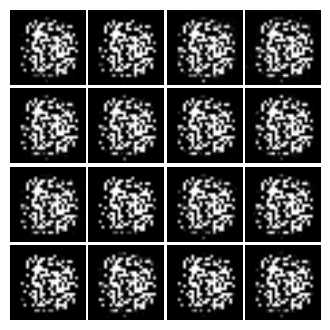

[      1] D_loss: 0.0093 / G_loss: 6.6956
[      2] D_loss: 0.0019 / G_loss: 7.7667
[      3] D_loss: 0.0309 / G_loss: 6.7130
[      4] D_loss: 0.0143 / G_loss: 6.0749
[      5] D_loss: 0.1169 / G_loss: 3.7039
[      6] D_loss: 0.0878 / G_loss: 5.8429
[      7] D_loss: 0.2117 / G_loss: 4.3921
[      8] D_loss: 0.1430 / G_loss: 3.8917
[      9] D_loss: 0.4094 / G_loss: 3.2709
[     10] D_loss: 0.2084 / G_loss: 4.0143


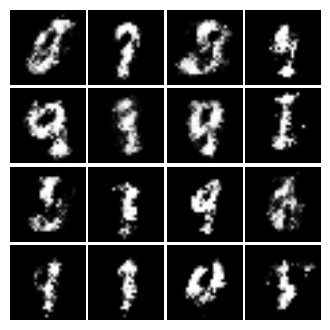

[     11] D_loss: 0.4252 / G_loss: 3.6346
[     12] D_loss: 0.5313 / G_loss: 2.8406
[     13] D_loss: 0.5479 / G_loss: 3.1998
[     14] D_loss: 0.4830 / G_loss: 2.5574
[     15] D_loss: 0.3921 / G_loss: 3.1743
[     16] D_loss: 0.5431 / G_loss: 2.5794
[     17] D_loss: 0.6138 / G_loss: 2.2566
[     18] D_loss: 0.6326 / G_loss: 2.6801
[     19] D_loss: 0.8022 / G_loss: 2.2745
[     20] D_loss: 0.4153 / G_loss: 2.5042


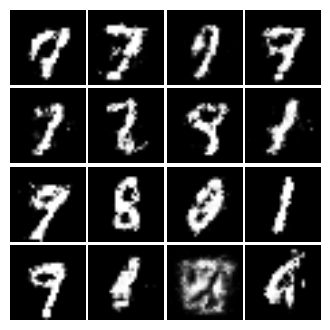

[     21] D_loss: 0.4995 / G_loss: 2.8842
[     22] D_loss: 0.5925 / G_loss: 2.3802
[     23] D_loss: 0.6665 / G_loss: 2.3011
[     24] D_loss: 0.5266 / G_loss: 2.6041
[     25] D_loss: 0.7771 / G_loss: 1.9775
[     26] D_loss: 0.5057 / G_loss: 2.3903
[     27] D_loss: 0.6818 / G_loss: 2.5380
[     28] D_loss: 0.7094 / G_loss: 2.7046
[     29] D_loss: 0.7386 / G_loss: 1.9182
[     30] D_loss: 0.6434 / G_loss: 2.2952


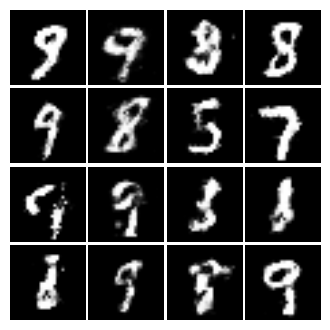

[     31] D_loss: 0.7018 / G_loss: 2.1083
[     32] D_loss: 0.6437 / G_loss: 2.0880
[     33] D_loss: 0.6667 / G_loss: 2.0343
[     34] D_loss: 0.5675 / G_loss: 2.5795
[     35] D_loss: 0.6032 / G_loss: 2.2711
[     36] D_loss: 0.6637 / G_loss: 2.0510
[     37] D_loss: 0.6075 / G_loss: 2.2763
[     38] D_loss: 0.6096 / G_loss: 2.3245
[     39] D_loss: 0.6649 / G_loss: 2.2694
[     40] D_loss: 0.6318 / G_loss: 1.9391


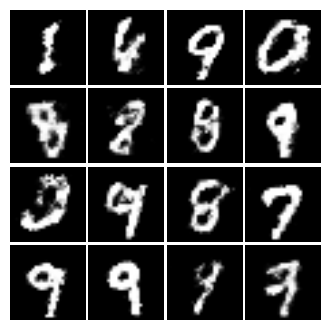

[     41] D_loss: 0.5379 / G_loss: 2.3281
[     42] D_loss: 0.7718 / G_loss: 2.1622
[     43] D_loss: 0.5583 / G_loss: 2.6674
[     44] D_loss: 0.7246 / G_loss: 2.0926
[     45] D_loss: 0.5180 / G_loss: 2.6803
[     46] D_loss: 0.5217 / G_loss: 2.2644
[     47] D_loss: 0.5747 / G_loss: 2.8923
[     48] D_loss: 0.5911 / G_loss: 2.8798
[     49] D_loss: 0.6818 / G_loss: 1.8777
[     50] D_loss: 0.6524 / G_loss: 2.9273


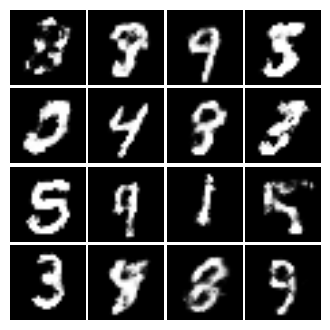

[     51] D_loss: 0.4488 / G_loss: 2.2419
[     52] D_loss: 0.7325 / G_loss: 2.6329
[     53] D_loss: 0.5989 / G_loss: 2.2466
[     54] D_loss: 0.8023 / G_loss: 2.7055
[     55] D_loss: 0.6986 / G_loss: 2.0051
[     56] D_loss: 0.9874 / G_loss: 2.1653
[     57] D_loss: 0.8043 / G_loss: 2.6895
[     58] D_loss: 0.5827 / G_loss: 2.4880
[     59] D_loss: 0.5787 / G_loss: 2.6751
[     60] D_loss: 0.6902 / G_loss: 2.2326


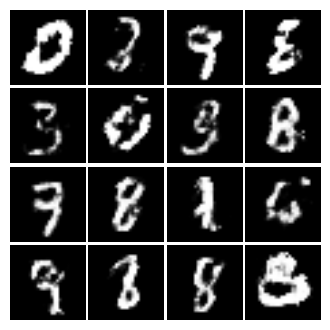

[     61] D_loss: 0.5583 / G_loss: 2.5918
[     62] D_loss: 0.6525 / G_loss: 2.5472
[     63] D_loss: 0.5984 / G_loss: 2.5017
[     64] D_loss: 0.6442 / G_loss: 2.4769
[     65] D_loss: 0.5144 / G_loss: 2.8408
[     66] D_loss: 0.4696 / G_loss: 2.5345
[     67] D_loss: 0.5838 / G_loss: 2.3447
[     68] D_loss: 0.5883 / G_loss: 2.5857
[     69] D_loss: 0.6617 / G_loss: 2.2295
[     70] D_loss: 0.9553 / G_loss: 2.8101


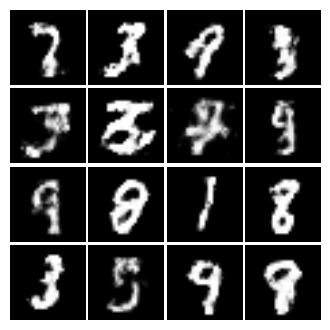

[     71] D_loss: 0.4788 / G_loss: 2.7080
[     72] D_loss: 0.6809 / G_loss: 2.5300
[     73] D_loss: 0.4833 / G_loss: 2.6594
[     74] D_loss: 0.4773 / G_loss: 2.6229
[     75] D_loss: 0.5485 / G_loss: 2.4511
[     76] D_loss: 0.5125 / G_loss: 2.5107
[     77] D_loss: 0.6172 / G_loss: 2.0993
[     78] D_loss: 0.5801 / G_loss: 2.5595
[     79] D_loss: 0.5639 / G_loss: 2.3868
[     80] D_loss: 0.5528 / G_loss: 2.5586


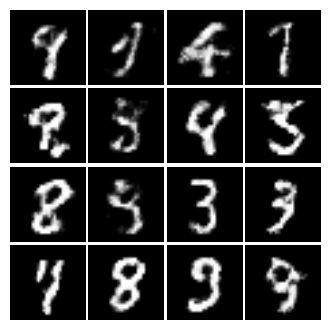

[     81] D_loss: 0.6631 / G_loss: 2.2426
[     82] D_loss: 0.4239 / G_loss: 3.0077
[     83] D_loss: 0.6622 / G_loss: 2.7057
[     84] D_loss: 0.6990 / G_loss: 2.3075
[     85] D_loss: 0.6534 / G_loss: 2.4197
[     86] D_loss: 0.5387 / G_loss: 2.0058
[     87] D_loss: 0.5664 / G_loss: 2.4075
[     88] D_loss: 0.5194 / G_loss: 2.5527
[     89] D_loss: 0.5795 / G_loss: 2.7123
[     90] D_loss: 0.6934 / G_loss: 2.8508


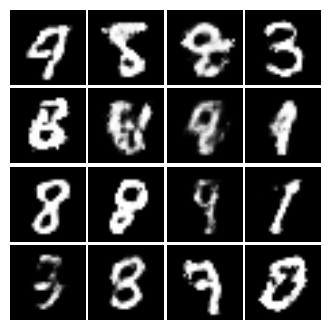

[     91] D_loss: 0.4559 / G_loss: 2.4453
[     92] D_loss: 0.5496 / G_loss: 2.7245
[     93] D_loss: 0.6291 / G_loss: 2.4522
[     94] D_loss: 0.4061 / G_loss: 2.6340
[     95] D_loss: 0.5332 / G_loss: 2.6052
[     96] D_loss: 0.4851 / G_loss: 2.5461
[     97] D_loss: 0.6642 / G_loss: 2.2285
[     98] D_loss: 0.5527 / G_loss: 2.5140
[     99] D_loss: 0.7785 / G_loss: 2.1554
elapsed:  197.158101082


In [20]:
sess = tf.Session()
# sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./tmp2/", sess.graph)

epoch_n = 100

st = time.time()

for epoch in range(epoch_n):
    # _ 는 원래 Y 임.
    for _ in range(N // batch_size):
        X_batch, _ = mnist.train.next_batch(batch_size)

#         _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, Z_dim)})
#         _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
        _, _, D_loss_curr, G_loss_curr = sess.run([D_solver, G_solver, D_loss, G_loss], 
                                                {X:X_batch, Z: sample_Z(batch_size, Z_dim)})
    
    print("[{:7d}] D_loss: {:.4f} / G_loss: {:.4f}".format(epoch, D_loss_curr, G_loss_curr))

    if epoch % 10 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()

print "elapsed: ", time.time() - st

[      0] D_loss: 0.0118 / G_loss: 6.3146


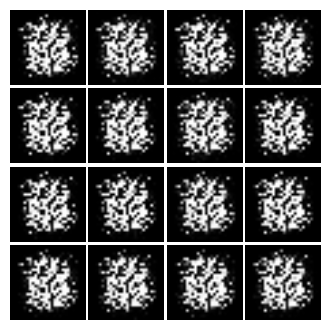

[      1] D_loss: 0.0493 / G_loss: 5.9463
[      2] D_loss: 0.0223 / G_loss: 5.0883
[      3] D_loss: 0.2083 / G_loss: 5.3528
[      4] D_loss: 0.1763 / G_loss: 4.5651
[      5] D_loss: 0.2148 / G_loss: 3.8743
[      6] D_loss: 0.3025 / G_loss: 3.4404
[      7] D_loss: 0.2329 / G_loss: 4.1760
[      8] D_loss: 0.6668 / G_loss: 2.9527
[      9] D_loss: 0.5030 / G_loss: 3.0675
[     10] D_loss: 0.6891 / G_loss: 2.7865


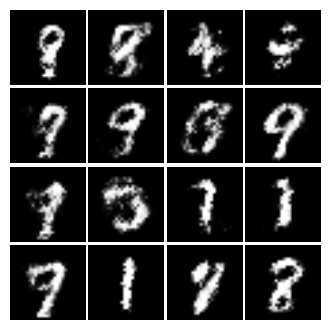

[     11] D_loss: 0.4695 / G_loss: 3.4158
[     12] D_loss: 0.5848 / G_loss: 2.4213
[     13] D_loss: 0.5111 / G_loss: 2.5468
[     14] D_loss: 0.6960 / G_loss: 2.7154
[     15] D_loss: 0.6531 / G_loss: 2.7879
[     16] D_loss: 0.7894 / G_loss: 2.2319
[     17] D_loss: 0.8047 / G_loss: 2.1634
[     18] D_loss: 0.6679 / G_loss: 2.1294
[     19] D_loss: 0.6738 / G_loss: 2.1202
[     20] D_loss: 0.9297 / G_loss: 1.7936


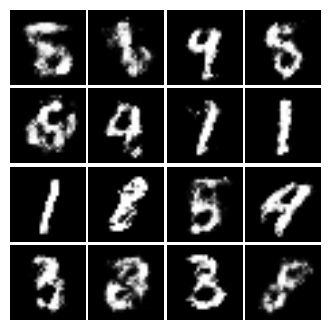

[     21] D_loss: 0.8090 / G_loss: 1.9525
[     22] D_loss: 0.7354 / G_loss: 1.8397
[     23] D_loss: 0.6744 / G_loss: 2.0712
[     24] D_loss: 0.8384 / G_loss: 2.0655
[     25] D_loss: 0.8624 / G_loss: 1.7041
[     26] D_loss: 0.8097 / G_loss: 1.9920
[     27] D_loss: 0.8448 / G_loss: 1.9072
[     28] D_loss: 0.8722 / G_loss: 1.9854
[     29] D_loss: 0.7939 / G_loss: 1.9274
[     30] D_loss: 0.7309 / G_loss: 1.7822


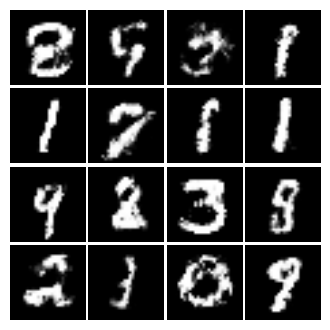

[     31] D_loss: 0.9251 / G_loss: 1.8434
[     32] D_loss: 0.9130 / G_loss: 1.9918
[     33] D_loss: 0.9514 / G_loss: 1.5453
[     34] D_loss: 0.6796 / G_loss: 2.0746
[     35] D_loss: 0.7786 / G_loss: 2.0414
[     36] D_loss: 0.7807 / G_loss: 1.7102
[     37] D_loss: 0.8257 / G_loss: 1.7322
[     38] D_loss: 0.7771 / G_loss: 1.8574
[     39] D_loss: 0.7911 / G_loss: 1.7936
[     40] D_loss: 0.6724 / G_loss: 2.4145


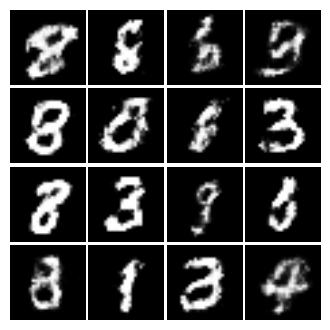

[     41] D_loss: 0.6639 / G_loss: 1.6849
[     42] D_loss: 0.7310 / G_loss: 1.8652
[     43] D_loss: 0.5780 / G_loss: 1.8947
[     44] D_loss: 0.9315 / G_loss: 2.3521
[     45] D_loss: 0.8028 / G_loss: 1.9451
[     46] D_loss: 0.7421 / G_loss: 2.0052
[     47] D_loss: 0.6533 / G_loss: 2.1358
[     48] D_loss: 0.7900 / G_loss: 2.4315
[     49] D_loss: 0.7895 / G_loss: 2.3387
[     50] D_loss: 0.7446 / G_loss: 2.3428


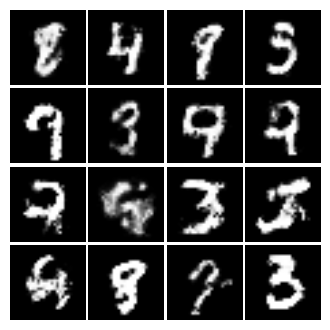

[     51] D_loss: 0.6973 / G_loss: 1.8831
[     52] D_loss: 0.7088 / G_loss: 2.2991
[     53] D_loss: 0.5430 / G_loss: 2.1802
[     54] D_loss: 0.4965 / G_loss: 2.2517
[     55] D_loss: 0.5488 / G_loss: 2.0825
[     56] D_loss: 0.6506 / G_loss: 2.6499
[     57] D_loss: 0.7007 / G_loss: 2.0967
[     58] D_loss: 0.7374 / G_loss: 2.5673
[     59] D_loss: 0.5401 / G_loss: 2.6749
[     60] D_loss: 0.4531 / G_loss: 2.2584


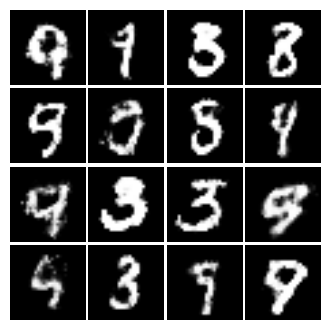

[     61] D_loss: 0.5734 / G_loss: 2.5066
[     62] D_loss: 0.6944 / G_loss: 2.4759
[     63] D_loss: 0.4770 / G_loss: 2.3220
[     64] D_loss: 0.5583 / G_loss: 2.5155
[     65] D_loss: 0.5711 / G_loss: 2.8339
[     66] D_loss: 0.5601 / G_loss: 3.0919
[     67] D_loss: 0.4294 / G_loss: 2.5962
[     68] D_loss: 0.5552 / G_loss: 2.1928
[     69] D_loss: 0.7954 / G_loss: 1.9528
[     70] D_loss: 0.6377 / G_loss: 2.5809


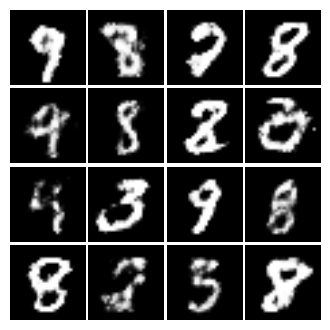

[     71] D_loss: 0.6879 / G_loss: 2.1061
[     72] D_loss: 0.5623 / G_loss: 2.4562
[     73] D_loss: 0.5330 / G_loss: 2.4736
[     74] D_loss: 0.8398 / G_loss: 2.4129
[     75] D_loss: 0.5657 / G_loss: 2.5209
[     76] D_loss: 0.5307 / G_loss: 2.4711
[     77] D_loss: 0.5850 / G_loss: 2.5485
[     78] D_loss: 0.5729 / G_loss: 2.2293
[     79] D_loss: 0.5450 / G_loss: 2.7881
[     80] D_loss: 0.3930 / G_loss: 2.4440


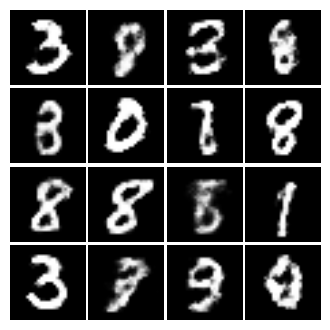

[     81] D_loss: 0.4450 / G_loss: 2.3762
[     82] D_loss: 0.5015 / G_loss: 2.3669
[     83] D_loss: 0.5496 / G_loss: 2.2805
[     84] D_loss: 0.5587 / G_loss: 2.7361
[     85] D_loss: 0.5605 / G_loss: 2.5888
[     86] D_loss: 0.5758 / G_loss: 2.6229
[     87] D_loss: 0.6320 / G_loss: 2.6646
[     88] D_loss: 0.4908 / G_loss: 2.4847
[     89] D_loss: 0.5770 / G_loss: 2.5098
[     90] D_loss: 0.5137 / G_loss: 2.8041


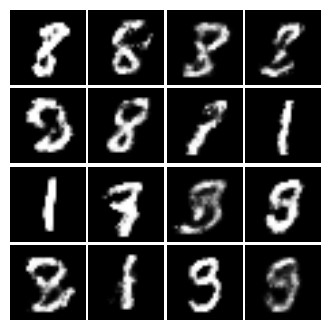

[     91] D_loss: 0.5221 / G_loss: 2.4177
[     92] D_loss: 0.6602 / G_loss: 2.0831
[     93] D_loss: 0.4464 / G_loss: 2.8537
[     94] D_loss: 0.3912 / G_loss: 2.8235
[     95] D_loss: 0.6945 / G_loss: 2.7252
[     96] D_loss: 0.7612 / G_loss: 2.6978
[     97] D_loss: 0.4157 / G_loss: 2.7133
[     98] D_loss: 0.5007 / G_loss: 2.8162
[     99] D_loss: 0.4627 / G_loss: 2.7167
elapsed:  289.966732979


In [21]:
sess = tf.Session()
# sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("./tmp2/", sess.graph)

epoch_n = 100

st = time.time()

for epoch in range(epoch_n):
    # _ 는 원래 Y 임.
    for _ in range(N // batch_size):
        X_batch, _ = mnist.train.next_batch(batch_size)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    
    print("[{:7d}] D_loss: {:.4f} / G_loss: {:.4f}".format(epoch, D_loss_curr, G_loss_curr))

    if epoch % 10 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()

print "elapsed: ", time.time() - st